# MediaPipe

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns

import vizualisation as viz
import mediapipe_holistic as mh

2025-04-11 21:42:39.980835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744375360.012880   15582 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744375360.022344   15582 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-11 21:42:40.055831: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# change working directory to the project root directory
current_dir = os.getcwd()
os.chdir(current_dir + '/../../')
# this should be the project root directory
os.getcwd()

'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage'

## Information

### MediaPipe Holistic 
#### [DOCS](https://github.com/google-ai-edge/mediapipe/blob/master/docs/solutions/holistic.md)

MediaPipe Holistic utilizes the pose, face and hand landmark models in [MediaPipe Pose](https://github.com/google-ai-edge/mediapipe/blob/master/docs/solutions/pose.md), [MediaPipe Face Mesh](https://github.com/google-ai-edge/mediapipe/blob/master/docs/solutions/face_mesh.md) and [MediaPipe Hands](https://github.com/google-ai-edge/mediapipe/blob/master/docs/solutions/hands.md) respectively to generate a total of 543 landmarks (33 pose landmarks, 468 face landmarks, and 21 hand landmarks per hand).

**INPUT**

480x480

**Output**

Naming style may differ slightly across platforms/languages.

**pose_landmarks**

A list of pose landmarks. Each landmark consists of the following:

- `x` and `y`: Landmark coordinates normalized to `[0.0, 1.0]` by the image width and height respectively.
- `z`: Should be discarded as currently the model is not fully trained to predict depth, but this is something on the roadmap.
- `visibility`: A value in `[0.0, 1.0]` indicating the likelihood of the landmark being visible (present and not occluded) in the image.

**pose_world_landmarks**

Another list of pose landmarks in world coordinates. Each landmark consists of the following:

- `x`, `y` and `z`: Real-world 3D coordinates in meters with the origin at the center between hips.
- `visibility`: Identical to that defined in the corresponding [pose_landmarks](https://github.com/google-ai-edge/mediapipe/blob/master/docs/solutions/holistic.md#pose_landmarks).

**face_landmarks**

A list of 468 face landmarks. Each landmark consists of `x`, `y` and `z`. `x` and `y` are normalized to `[0.0, 1.0]` by the image width and height respectively. `z` represents the landmark depth with the depth at center of the head being the origin, and the smaller the value the closer the landmark is to the camera. The magnitude of `z` uses roughly the same scale as `x`.

**left_hand_landmarks**

A list of 21 hand landmarks on the left hand. Each landmark consists of `x`, `y` and `z`. `x` and `y` are normalized to `[0.0, 1.0]` by the image width and height respectively. `z` represents the landmark depth with the depth at the wrist being the origin, and the smaller the value the closer the landmark is to the camera. The magnitude of `z` uses roughly the same scale as `x`.

**right_hand_landmarks**

A list of 21 hand landmarks on the right hand, in the same representation as [left_hand_landmarks](https://github.com/google-ai-edge/mediapipe/blob/master/docs/solutions/holistic.md#left_hand_landmarks).

**segmentation_mask**

The output segmentation mask, predicted only when [enable_segmentation](https://github.com/google-ai-edge/mediapipe/blob/master/docs/solutions/holistic.md#enable_segmentation) is set to `true`. The mask has the same width and height as the input image, and contains values in `[0.0, 1.0]` where `1.0` and `0.0` indicate high certainty of a "human" and "background" pixel respectively. Please refer to the platform-specific usage examples below for usage details.

## Load Video Metadata

In [4]:
video_metadata_df = pd.read_csv('data/raw/combined/target_dataset_video_metadata.csv')

## Holistic Model

### Detect

In [5]:
i = 1
row = video_metadata_df.iloc[i]
video_path = f"data/raw/combined/videos/{row.filename}"
video_path

'data/raw/combined/videos/ajudar_sb_2.mp4'

In [6]:
# Initialize detector
mediapipe = mh.MediaPipeHolistic(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    model_complexity=1,  # 0=Lite, 1=Full, 2=Heavy
    refine_face_landmarks=True
)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1744375366.219073   15669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744375366.271587   15669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744375366.281527   15667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744375366.287740   15664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744375366.288630   15669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744375366.326468   15

In [7]:
landmarks = mediapipe.process_video(video_path)

W0000 00:00:1744375368.605770   15670 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


### Visualize

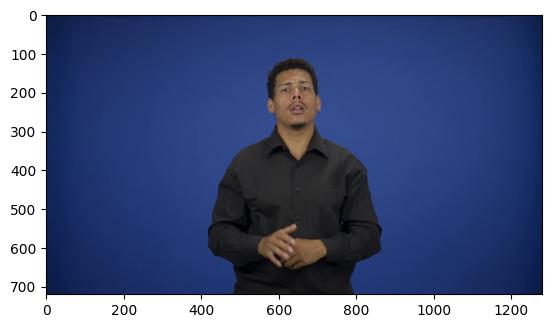

In [8]:
frame_index = 10
frame = viz.get_frame(frame_index, video_path)
plt.imshow(frame);

See landmarks on a square canvas

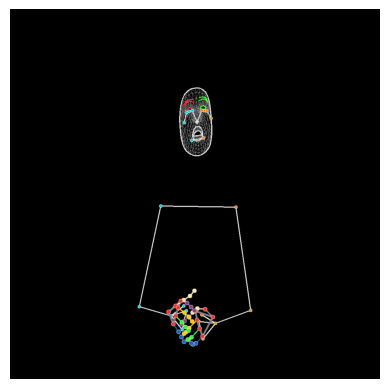

In [14]:
skeleton = viz.draw_landmarks_on_frame(np.zeros((1000,1000,3), dtype=np.uint8), landmarks[frame_index])
plt.imshow(skeleton[:,:,::-1])
plt.axis('off');

See landmarks drawn on their respective frame

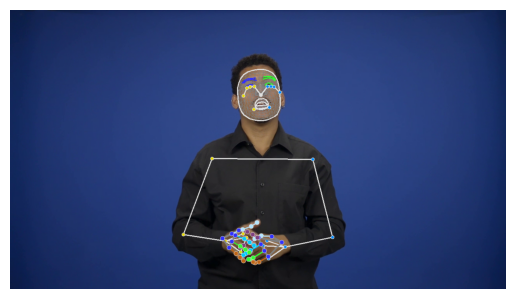

In [16]:
annotated_frame = viz.draw_landmarks_on_frame(frame, landmarks[frame_index])
plt.imshow(annotated_frame)
plt.axis('off');


Save a video with landmarks drawn on each frame

In [17]:
viz.draw_landmarks_on_video(video_path, landmarks, 'mediapipe_landmarks_example.mp4')

Landmarks drawn video saved to mediapipe_landmarks_example.mp4


3D Plot, showing that landmarks are also detected in 3D space

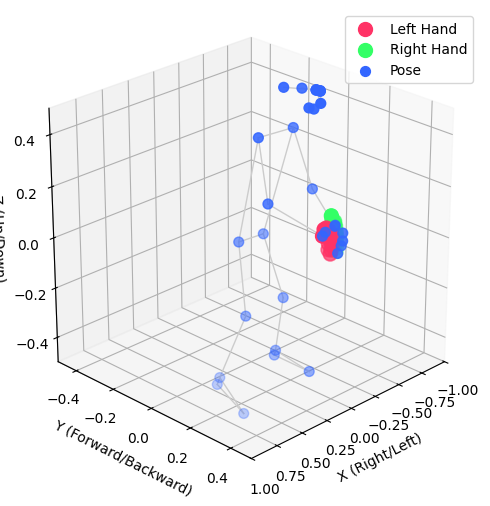

In [18]:
fig = viz.draw_landmarks_3d(
    landmarks[frame_index],
    figsize=(5, 5),
    elev=25,     # Look slightly from above
    azim=45,     # Look from the front
    xlim=(-1,1),
    ylim=(-.5,.5),
    zlim=(-.5,.5)
)
plt.show()

## Post Process

### Horizontal Alignment

We know the horizontal center should be 0.5, so we can use center the signer horizontally.

In [19]:
horizontal_offsets = mediapipe.get_video_horizontal_offsets(landmarks)
horizontal_offsets

{'shoulders': {'mean': 0.4949150662633437,
  'median': 0.4965493381023407,
  'max': 0.5088723599910736,
  'min': 0.48143619298934937},
 'face': {'mean': 0.4935306469096413,
  'median': 0.49642214179039,
  'max': 0.5097975134849548,
  'min': 0.47643500566482544}}

In [20]:
horizontal_offset = 0.5 - (horizontal_offsets['shoulders']['median'] + horizontal_offsets['face']['median'])/2
horizontal_offset

0.0035142600536346436

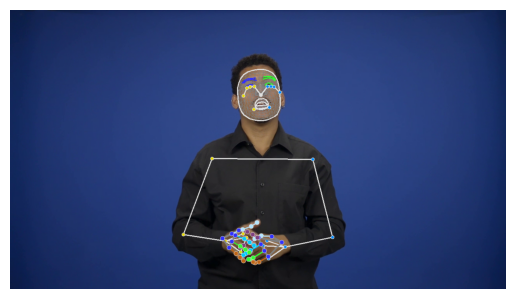

In [23]:
annotated_frame = viz.draw_landmarks_on_frame(frame, landmarks[frame_index])
plt.imshow(annotated_frame)
plt.axis('off');

In [24]:
horizontal_aligned_landmarks = mediapipe.shift_landmarks_series_horizontally(landmarks, horizontal_offset)

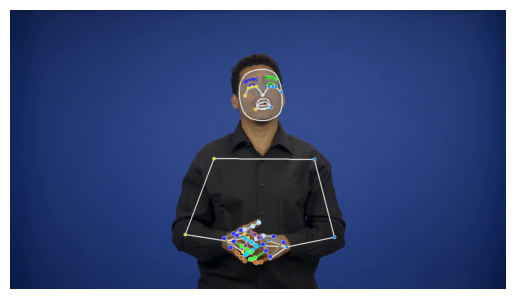

In [26]:
annotated_frame = viz.draw_landmarks_on_frame(frame, horizontal_aligned_landmarks[frame_index])
plt.imshow(annotated_frame)
plt.axis('off');

In [27]:
frame.shape[1]*horizontal_offset
horizontal_aligned_frame = np.hstack((frame[:,75:,:], frame[:,:75,:]))

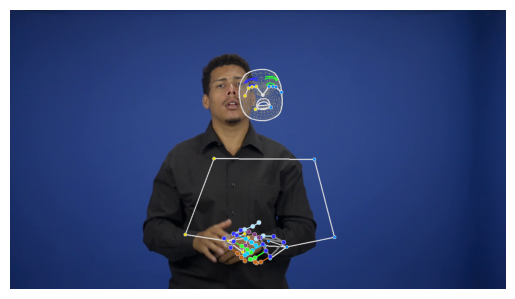

In [29]:
annotated_frame = viz.draw_landmarks_on_frame(horizontal_aligned_frame, horizontal_aligned_landmarks[frame_index])
plt.imshow(annotated_frame)
plt.axis('off');

### Scaling

In [33]:
measurements = mediapipe.get_video_landmark_measurements(landmarks)
pd.DataFrame(measurements).T

,mean,median,max
shoulder_width,0.180338,0.172927,0.200056
hip_width,0.122342,0.122392,0.127677
shoulder_to_hip,0.471220,0.468286,0.501800
left_arm_length,0.309800,0.284318,0.396285
right_arm_length,0.183952,0.131146,0.403019
face_width,0.085532,0.085351,0.087712
face_height,0.186483,0.185882,0.192367
top_head_to_shoulders,0.265184,0.260974,0.311634
nose_to_shoulders,0.182391,0.180683,0.237984
chin_to_shoulders,0.078847,0.071868,0.126097


#### Vertical Alignment